# Библиотеки

In [29]:
import pandas as pd
import numpy as np
import gc
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import catboost

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Константы

In [30]:
RAWDATADIR = '../data/raw'
DATADIR = '../data'

## Словарь по целевым постам

In [31]:
kirensk_dict = {
    'name': 'Киренск',
    'id': 3019,
    'meteo_st': [30028, 30219, 30328, 30337, 30433, 30230],
    'gydro_st': [3087, 3021],
    'id_influencer': [],
    'std_sq': 185.35707752426708
}

vitim_dict = {
    'name': 'Витим',
    'id': 3027,
    'meteo_st': [24713, 24726, 24817, 30356, 30471, 30372, 30069, 30253, 30252, 24923],
    'gydro_st': [3106, 3555, 3024, 3554, 3028, 3029, 3030, 3031, 3032],
    'id_influencer': [3019],
    'std_sq': 1223.8071616577856
}

peledui_dict = {
    'name': 'Пеледуй',
    'id': 3028,
    'meteo_st': [24713, 24726, 24817, 30356, 30471, 30372, 30069, 30253, 30252, 24923],
    'gydro_st': [3106, 3555, 3024, 3554, 3027, 3029, 3030, 3031, 3032],
    'id_influencer': [3019, 3027],
    'std_sq': 1357.4062812989373
}

krestovskiy_dict = {
    'name': 'Крестовский Лесоучасток',
    'id': 3029,
    'meteo_st': [24713, 24726, 24817, 30356, 30471, 30372, 30069, 30253, 30252, 24923],
    'gydro_st': [3106, 3555, 3024, 3554, 3027, 3028, 3030, 3031, 3032],
    'id_influencer': [3019, 3027, 3028],
    'std_sq': 1520.7730161870682
}

lensk_dict = {
    'name': 'Ленск',
    'id': 3030,
    'meteo_st': [24713, 24726, 24817, 30356, 30471, 30372, 30069, 30253, 30252, 24923],
    'gydro_st': [3106, 3555, 3024, 3554, 3027, 3028, 3029, 3031, 3032],
    'id_influencer': [3019, 3027, 3028, 3029],
    'std_sq': 1765.9217904996142
}

olekminsk_dict = {
    'name': 'Олекминск',
    'id': 3035,
    'meteo_st': [24538,24738,24641,24933,30089,30385,30493,30393,31102,31004,24951,24944],
    'gydro_st': [3180,3169,3036,3037,3038],
    'id_influencer': [3019, 3027, 3028, 3029, 3030],
    'std_sq': 765.3703832632036
}

pokrovsk_dict = {
    'name': 'Покровск',
    'id': 3041,
    'meteo_st': [31137,31026,24967,24966,24641,24643,24661,24671,24763],
    'gydro_st': [3042,3045,3047,3048],
    'id_influencer': [3019, 3027, 3028, 3029, 3030, 3035],
    'std_sq': 443.5766934006718
}

yakutsk_dict = {
    'name': 'Якутск',
    'id': 3045,
    'meteo_st': [31137,31026,24967,24966,24641,24643,24661,24671,24763],
    'gydro_st': [3042,3041,3047,3048],
    'id_influencer': [3019, 3027, 3028, 3029, 3030, 3035, 3041],
    'std_sq': 579.1353554017562
}

batamay_dict = {
    'name': 'Батамай',
    'id': 3230,
    'meteo_st': [31137,31026,24967,24966,24641,24643,24661,24671,24763],
    'gydro_st': [3229,3050],
    'id_influencer': [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045],
    'std_sq': 516.6669876251401
}

sangar_dict = {
    'name': 'Сангар',
    'id': 3050,
    'meteo_st': [31137,31026,24967,24966,24641,24643,24661,24671,24763],
    'gydro_st': [3229,3230],
    'id_influencer': [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045, ],
    'std_sq': 612.0471238561079
}

target_stations = [
    kirensk_dict, 
    vitim_dict, 
    peledui_dict, 
    krestovskiy_dict, 
    lensk_dict, 
    olekminsk_dict, 
    pokrovsk_dict,
    yakutsk_dict,
    batamay_dict,
    sangar_dict
]

# Методы

## make_gydro_df

In [32]:
def make_gydro_df(train_df, station_dict, verbose=False):
    """
    Формирует датасет с гидрологическими данными
    """

    tr_data = df_preprocessing(train_df, station_dict['id'])

    # соберём данные со смежных постов, выделенных в словаре по данному целевому посту
    mapper = dict()
    use_feature = ['date', 'stage_avg', 'stage_min','stage_max', 'temp', 'water_code', 'ice_thickness','snow_height', 
                   'place', 'discharge']

    for n, st in enumerate(station_dict['gydro_st']):
        if n == 0:
            # данные с поста
            df = df_preprocessing(train_df, st)
            df = df[use_feature]
            for col in [x for x in use_feature if x not in ['date']]:
                mapper[col] = f'{col}_{st}'
            gydro_st = df.rename(columns=mapper)
        else:
            # данные с поста
            df = df_preprocessing(train_df, st)
            df = df[use_feature]
            for col in [x for x in use_feature if x not in ['date']]:
                mapper[col] = f'{col}_{st}'
            df.rename(columns=mapper, inplace=True)
            gydro_st = pd.merge(gydro_st, df, how='outer', on='date')
            
    # сводные данные по целевому посту и его окресных гидропостов
    return pd.merge(tr_data, gydro_st, how='left', on='date').fillna(-777)

## make_meteo_df

In [33]:
def make_meteo_df(meteo_df, stations_id, verbose=False):
    """
    Формирует датасет с метеорологическим данными
    """
    # Замена np.nan'ами неподтверждённых или опровергнутых данных
    _qual_cols = list(meteo_df.filter(regex='_qual$').columns)
    if verbose: print(meteo_df.shape)
    for col in _qual_cols:
        meteo_df = mute_untrastable(meteo_df, col)
    if verbose: print(meteo_df.shape)

    features = pd.Series(_qual_cols)
    spl_feat = []
    for n, f in enumerate(features):
        spl = features.values[n].split('_')
        spl_feat.append(('_'.join(spl[:len(spl)-1])))

    use_feature = ['station_id', 'date_local', 'month_local'] + spl_feat

    meteo_data = meteo_df[use_feature].copy()
    if verbose: print(meteo_data.shape)
    del meteo_df
    gc.collect()
    
    # аггрегация данных с дискретностью 1 день
    meteo_1day = meteo_data.groupby(['station_id', 'date_local']).median()
    meteo_1day.reset_index(inplace=True)
    if verbose: print(meteo_1day.shape)
    del meteo_data
    gc.collect()
    
    mapper = dict()
    use_feature = ['date_local', 'month_local'] + spl_feat

    # берём данные по нужным станциям
    for n, st in enumerate(stations_id):
        if verbose: print(n, st)
        if n == 0:
            df = meteo_data_processing(meteo_1day, st)
            df = df[use_feature]
            if verbose: print(df.shape)
            for col in spl_feat:
                mapper[col] = f'{col}_{st}'
            meteo_st = df.rename(columns=mapper)
        else:
            df = meteo_data_processing(meteo_1day, st)
            df = df[use_feature]
            if verbose: print(df.shape)
            for col in spl_feat:
                mapper[col] = f'{col}_{st}'
            df.rename(columns=mapper, inplace=True)
            meteo_st = pd.merge(meteo_st, df, how='outer', on=['date_local', 'month_local'])
            
        
    # находим значения для заполнения праметров с пропусками, учитывая специфику каждого месяца
    features_dict = dict()
    features = [x for x in meteo_st.columns if x not in ['date_local', 'month_local']]
    for f in features:
        features_dict[f] = dict()
    for feature in features:
        for i in range(1, 13):
            val = meteo_st.loc[meteo_st.month_local == i, feature].median()
            if (val is not np.nan)|(val is not pd.NA)|(val != 'nan'):
                features_dict[feature][i] = val
            else:
                features_dict[feature][i] = -777
    # заполняем пропуски
    for col in features:
        for i in range(1,13):
            meteo_st.loc[(meteo_st.month_local == i)&(meteo_st[col].isna()), col] = features_dict[col][i]
                
    meteo_st.fillna(-777, inplace=True)
    
    return meteo_st

## df_preprocessing

In [34]:
def df_preprocessing(df, station_id, verbose=False):
    """
    Предобработка данных по указанной гидростанции станции
    """
    tr_data = df[(df.station_id == station_id)].copy()

    # если замер льда не делали, то пусть 0 будет такой категорией
    tr_data['place'].fillna(0, inplace=True)
    # water_code и place должны быть категориальными
    tr_data['water_code'] = tr_data['water_code'].astype('str')
    tr_data['place'] = tr_data['place'].astype('int8')
    
    # проверка признаков на наличие пропусков
    na_features = []
    if verbose: print('Пропуски:')
    for col in tr_data.columns:
        cnt = tr_data[col].isna().sum()
        if cnt > 0:
            if verbose: print(col, ':', cnt)
            na_features.append(col)
    if verbose: print()
    if len(na_features) > 0:
        # находим значения для заполнения праметров с пропусками, учитывая специфику каждого месяца
        na_features_dict = dict()
        for f in na_features:
            na_features_dict[f] = dict()
        for feature in na_features:
            for i in range(1, 13):
                val = tr_data.loc[tr_data.month == i, feature].median()
                # признак если среднего расхода воды не знаем или не замеряется на посту
                if (val is np.nan)&(feature == 'discharge'):
                    na_features_dict[feature][i] = -1
                elif val is np.nan:
                    na_features_dict[feature][i] = 0.0
                else:
                    na_features_dict[feature][i] = val
        # заполняем пропуски
        for col in na_features:
            for i in range(1,13):
                tr_data.loc[(tr_data.month == i)&(tr_data[col].isna()), col] = na_features_dict[col][i]
            
    return tr_data

## mute_untrastable

In [35]:
def mute_untrastable(df, feature):
    """
    Замена NaN'ами неподтверждённых или опровергнутых данных
    feature - фича с суфиксом _qual
    """
    spl = feature.split('_')
    spl_feat = ('_').join(spl[:len(spl)-1])
    
    df.loc[df[feature] > 2, spl_feat] = np.nan
    
    return df

## meteo_data_processing

In [36]:
def meteo_data_processing(meteo_1day, station_id, verbose=False):
    """
    Предобработка метеоданных
    meteo_1day - dataframe с метеоданными, аггрегированные за 1 день
    """
    
    df = meteo_1day[(meteo_1day.station_id == station_id)].copy()
    
    # проверка признаков на наличие пропусков
    na_features = []
    if verbose: print('Пропуски:')
    for col in df.columns:
        cnt = df[col].isna().sum()
        if cnt > 0:
            if verbose: print(col, ':', cnt)
            na_features.append(col)
            
    if len(na_features) > 0:
        # находим значения для заполнения праметров с пропусками, учитывая специфику каждого месяца
        na_features_dict = dict()
        for f in na_features:
            na_features_dict[f] = dict()
        for feature in na_features:
            for i in range(1, 13):
                val = df.loc[df.month_local == i, feature].median()
                if (val is np.nan):
                    na_features_dict[feature][i] = -777
                else:
                    na_features_dict[feature][i] = val
                        
        # заполняем пропуски
        for col in na_features:
            for i in range(1,13):
                df.loc[(df.month_local == i)&(df[col].isna()), col] = na_features_dict[col][i]
            
    return df

# Submit

verbose=False
for st_dict in target_stations:
    print(st_dict['name'])
    # формируем датасет
    print('формируем датасет')
    gydro_df = make_gydro_df(
        pd.read_csv(f'{RAWDATADIR}/track_2_package/train.csv', parse_dates=['date']),
        st_dict
    )
    if verbose: print('gydro_df', gydro_df.shape)

    meteo_df = make_meteo_df(
        pd.read_csv(f'{RAWDATADIR}/track_2_package/meteo_3hours.csv', parse_dates=['date_local']),
        st_dict['meteo_st']
    )
    if verbose: print('meteo_df', meteo_df.shape)

    train_data = pd.merge(gydro_df, meteo_df.rename(columns={'date_local': 'date'}), how='left', on='date')
    if verbose: print('train_data',train_data.shape)

    train_data.fillna(-777, inplace=True)
    if verbose: print('NaNs', sum(train_data.isna().sum()))
    if verbose: print('train_data', train_data.shape)

    with open(f"datasets/{st_dict['name']}_sub_data.pkl", 'wb') as f:
        pickle.dump(train_data, f)

In [5]:
mapper = dict()

for st in target_stations:
    mapper[st['id']] = st['name']
    
mapper

{3019: 'Киренск',
 3027: 'Витим',
 3028: 'Пеледуй',
 3029: 'Крестовский Лесоучасток',
 3030: 'Ленск',
 3035: 'Олекминск',
 3041: 'Покровск',
 3045: 'Якутск',
 3230: 'Батамай',
 3050: 'Сангар'}

In [7]:
submit = pd.read_csv('../data/raw/test_data/2_track_cp4/test.csv', parse_dates=['date'])

verbose=False
for i in range(0, len(submit), 7):
    if verbose: print(i)
    target_date = submit.loc[i, 'date']
    target_st = submit.loc[i, 'station_id']
    data_date = target_date - pd.Timedelta(days=1)
    if verbose: print('target_date',target_date)
    if verbose: print('target_st',target_st)
    if verbose: print('data_date',data_date)
    with open(f"datasets/{mapper[target_st]}_sub_data.pkl", 'rb') as f:
        data = pickle.load(f)
    input_data = data[(data.station_id==target_st)&(data.date==data_date)]
    if verbose: display(input_data)
    wcode = list(input_data.filter(regex='water_code').columns)
    target = list(input_data.filter(regex='delta_stage_max').columns)
    X = input_data.drop(['station_id','date','year']+wcode+target,axis=1).to_numpy()
    if verbose: print('X.shape', X.shape)
    if len(X) > 0:
        for j in range(1,8):
            with open(f"models/model_{target_st}_{j}.pkl", 'rb') as f:
                model = pickle.load(f)
            submit.loc[i, 'delta_stage_max'] = model.predict(X)
            i += 1
    else:
        submit.loc[i, 'delta_stage_max'] = np.nan
        i += 1

In [18]:
submit[submit.station_id==3045]

,year,station_id,month,day,date,delta_stage_max
231,1993,3045,4,111,1993-04-21,2.112000
232,1993,3045,4,112,1993-04-22,2.351785
233,1993,3045,4,113,1993-04-23,-2.025719
234,1993,3045,4,114,1993-04-24,-1.409916
235,1993,3045,4,115,1993-04-25,-0.028481
...,...,...,...,...,...,...
2424,2013,3045,5,134,2013-05-14,NaN
2425,2013,3045,5,135,2013-05-15,NaN
2426,2013,3045,5,136,2013-05-16,NaN
2427,2013,3045,5,137,2013-05-17,NaN


# Baseline

In [9]:
# Киренск
gydro_df = make_gydro_df(
    pd.read_csv(f'{RAWDATADIR}/track_2_package/train.csv', parse_dates=['date']),
    kirensk_dict
)
gydro_df.shape

(11604, 33)

In [10]:
meteo_df = make_meteo_df(
    pd.read_csv(f'{RAWDATADIR}/track_2_package/meteo_3hours.csv', parse_dates=['date_local']),
    kirensk_dict['meteo_st']
)
meteo_df.shape

(12310, 218)

In [11]:
data = pd.merge(gydro_df, meteo_df.rename(columns={'date_local': 'date'}), how='left', on='date')
data.shape

(11604, 250)

In [12]:
sum(data.isna().sum())

70631

In [13]:
data.fillna(-777, inplace=True)
sum(data.isna().sum())

0

In [14]:
data['delta_stage_max_1'] = data.delta_stage_max.shift(1)
data['delta_stage_max_2'] = data.delta_stage_max.shift(2)
data['delta_stage_max_3'] = data.delta_stage_max.shift(3)
data['delta_stage_max_4'] = data.delta_stage_max.shift(4)
data['delta_stage_max_5'] = data.delta_stage_max.shift(5)
data['delta_stage_max_6'] = data.delta_stage_max.shift(6)
data['delta_stage_max_7'] = data.delta_stage_max.shift(7)

data.dropna(inplace=True)
data.shape

(11597, 257)

In [15]:
with open(f"{kirensk_dict['name']}_train_data.pkl", 'wb') as f:
    pickle.dump(data, f)

In [17]:
list(data.columns)

['station_id',
 'date',
 'stage_avg',
 'stage_min',
 'stage_max',
 'temp',
 'water_code',
 'ice_thickness',
 'snow_height',
 'place',
 'discharge',
 'year',
 'month',
 'day',
 'delta_stage_max',
 'stage_avg_3087',
 'stage_min_3087',
 'stage_max_3087',
 'temp_3087',
 'water_code_3087',
 'ice_thickness_3087',
 'snow_height_3087',
 'place_3087',
 'discharge_3087',
 'stage_avg_3021',
 'stage_min_3021',
 'stage_max_3021',
 'temp_3021',
 'water_code_3021',
 'ice_thickness_3021',
 'snow_height_3021',
 'place_3021',
 'discharge_3021',
 'month_local',
 'horizontal_visibility_30028',
 'cloud_amount_total_30028',
 'cloud_amount_low_level_30028',
 'cloud_form_high_level_30028',
 'cloud_form_middle_level_30028',
 'cloud_form_vertical_develop_30028',
 'cloud_form_strat_stratocum_30028',
 'cloud_form_strat_rain_30028',
 'cloud_base_altitude_30028',
 'cloud_below_station_30028',
 'soil_surface_condition_30028',
 'weather_before_30028',
 'weather_30028',
 'wind_direction_30028',
 'wind_speed_aver_30028

In [40]:
wc = list(data.filter(regex='water_code').columns)
target = list(data.filter(regex='delta_stage_max').columns)
X = data.drop(['station_id','date','year']+wc+target,axis=1).to_numpy()
# X = data.drop(['station_id','date','delta_stage_max']+wc,axis=1).to_numpy()
y = data.delta_stage_max.to_numpy()
y1 = data.delta_stage_max_1.to_numpy()
y2 = data.delta_stage_max_2.to_numpy()
y3 = data.delta_stage_max_3.to_numpy()
y4 = data.delta_stage_max_4.to_numpy()
y5 = data.delta_stage_max_5.to_numpy()
y6 = data.delta_stage_max_6.to_numpy()
y7 = data.delta_stage_max_7.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.2, random_state=13)
_, _, y1_train, y1_test = train_test_split(X, y1, shuffle=False, train_size=0.2, random_state=13)
_, _, y2_train, y2_test = train_test_split(X, y2, shuffle=False, train_size=0.2, random_state=13)
_, _, y3_train, y3_test = train_test_split(X, y3, shuffle=False, train_size=0.2, random_state=13)
_, _, y4_train, y4_test = train_test_split(X, y4, shuffle=False, train_size=0.2, random_state=13)
_, _, y5_train, y5_test = train_test_split(X, y5, shuffle=False, train_size=0.2, random_state=13)
_, _, y6_train, y6_test = train_test_split(X, y6, shuffle=False, train_size=0.2, random_state=13)
_, _, y7_train, y7_test = train_test_split(X, y7, shuffle=False, train_size=0.2, random_state=13)

In [19]:
kirensk_dict['id']

3019

In [41]:
params = {
    'iterations': 3000,
    'eval_metric': 'RMSE',
    'random_seed': 13,
    'use_best_model': True
}

print('model_3019')
model_3019 = catboost.CatBoostRegressor(**params)
model_3019.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=3000
)
print('model_3019_1')
model_3019_1 = catboost.CatBoostRegressor(**params)
model_3019_1.fit(
    X_train, y1_train,
    eval_set=(X_test, y1_test),
    verbose=3000
)
print('model_3019_2')
model_3019_2 = catboost.CatBoostRegressor(**params)
model_3019_2.fit(
    X_train, y2_train,
    eval_set=(X_test, y2_test), 
    verbose=3000
)
print('model_3019_3')
model_3019_3 = catboost.CatBoostRegressor(**params)
model_3019_3.fit(
    X_train, y3_train,
    eval_set=(X_test, y3_test),  
    verbose=3000
)
print('model_3019_4')
model_3019_4 = catboost.CatBoostRegressor(**params)
model_3019_4.fit(
    X_train, y4_train,
    eval_set=(X_test, y4_test),  
    verbose=3000
)
print('model_3019_5')
model_3019_5 = catboost.CatBoostRegressor(**params)
model_3019_5.fit(
    X_train, y5_train,
    eval_set=(X_test, y5_test),  
    verbose=3000
)
print('model_3019_6')
model_3019_6 = catboost.CatBoostRegressor(**params)
model_3019_6.fit(
    X_train, y6_train,
    eval_set=(X_test, y6_test),  
    verbose=3000
)
print('model_3019_7')
model_3019_7 = catboost.CatBoostRegressor(**params)
model_3019_7.fit(
    X_train, y7_train,
    eval_set=(X_test, y7_test),  
    verbose=3000
)

model_3019
Learning rate set to 0.027245
0:	learn: 12.1835456	test: 12.4127636	best: 12.4127636 (0)	total: 10.5ms	remaining: 31.6s
2999:	learn: 1.0927607	test: 12.1775483	best: 11.9059295 (344)	total: 17.6s	remaining: 0us

bestTest = 11.90592953
bestIteration = 344

Shrink model to first 345 iterations.
model_3019_1
Learning rate set to 0.027245
0:	learn: 12.1620032	test: 12.3973327	best: 12.3973327 (0)	total: 7.13ms	remaining: 21.4s
2999:	learn: 0.9882874	test: 12.1722095	best: 11.8609571 (79)	total: 17.7s	remaining: 0us

bestTest = 11.86095712
bestIteration = 79

Shrink model to first 80 iterations.
model_3019_2
Learning rate set to 0.027245
0:	learn: 12.1628154	test: 12.4020443	best: 12.4020443 (0)	total: 6.54ms	remaining: 19.6s
2999:	learn: 1.0008010	test: 11.8199908	best: 11.5947957 (270)	total: 17.8s	remaining: 0us

bestTest = 11.59479568
bestIteration = 270

Shrink model to first 271 iterations.
model_3019_3
Learning rate set to 0.027245
0:	learn: 12.1320205	test: 12.3916551	bes

In [72]:
kirensk_dict['id']

3019

In [25]:
metric = mean_squared_error(y_test, model_3019.predict(X_test))/kirensk_dict['std_sq']
metric

0.7678782332775705

# Test

In [58]:
# собрать датасет
dirs = os.listdir('../data/raw/test_data')
files = os.listdir('../data/raw/test_data/2_track_cp3')
names = ['extra_train.csv','extra_meteo_3hours.csv']

gydro_raw = pd.DataFrame()
meteo_raw = pd.DataFrame()

for d in dirs:
    for f in files:
        if f in names:
            if f == 'extra_train.csv':
                gydro_raw = pd.concat([
                    gydro_raw, 
                    pd.read_csv(f'../data/raw/test_data/{d}/{f}', parse_dates=['date']),
                ])
            if f == 'extra_meteo_3hours.csv':
                meteo_raw = pd.concat([
                    meteo_raw,
                    pd.read_csv(f'../data/raw/test_data/{d}/{f}', parse_dates=['date_local']),
                ])
print('gydro_raw', gydro_raw.shape)
print('meteo_raw', meteo_raw.shape)

gydro_raw (2482, 15)
meteo_raw (46424, 94)


In [73]:
# Киренск
gydro_df = make_gydro_df(gydro_raw, kirensk_dict)
print('gydro_df', gydro_df.shape)

meteo_df = make_meteo_df(meteo_raw, kirensk_dict['meteo_st'])
print('meteo_df', meteo_df.shape)

test_data = pd.merge(gydro_df, meteo_df.rename(columns={'date_local': 'date'}), how='left', on='date')
print('test_data',test_data.shape)

test_data.fillna(-777, inplace=True)
print('NaNs', sum(test_data.isna().sum()))

# test_data['delta_stage_max_1'] = test_data.delta_stage_max.shift(1)
# test_data['delta_stage_max_2'] = test_data.delta_stage_max.shift(2)
# test_data['delta_stage_max_3'] = test_data.delta_stage_max.shift(3)
# test_data['delta_stage_max_4'] = test_data.delta_stage_max.shift(4)
# test_data['delta_stage_max_5'] = test_data.delta_stage_max.shift(5)
# test_data['delta_stage_max_6'] = test_data.delta_stage_max.shift(6)
# test_data['delta_stage_max_7'] = test_data.delta_stage_max.shift(7)

# test_data.dropna(inplace=True)
print('test_data', test_data.shape)

with open(f"{kirensk_dict['name']}_test_data.pkl", 'wb') as f:
    pickle.dump(test_data, f)

gydro_df (140, 33)
meteo_df (154, 218)
test_data (140, 250)
NaNs 0
test_data (140, 250)


In [90]:
wc = list(test_data.filter(regex='water_code').columns)
X = test_data.drop(['station_id','date','year','delta_stage_max']+wc,axis=1).to_numpy()
y = test_data.delta_stage_max.to_numpy()

In [91]:
metric = mean_squared_error(y, model_3019.predict(X))/kirensk_dict['std_sq']
metric

6.652152644785904

In [92]:
# формат для сабмита
pd.DataFrame({
    'year': test_data.year,
    'station_id': test_data.station_id,
    'month': test_data.month,
    'day': test_data.day,
    'date': test_data.date,
    'delta_stage_max':  model_3019.predict(X),
    'y': test_data.delta_stage_max
})

,year,station_id,month,day,date,delta_stage_max,y
0,1993,3019,5,132,1993-05-12,6.750468,3.0
1,1993,3019,5,133,1993-05-13,4.332843,-2.0
2,1993,3019,5,134,1993-05-14,12.405399,-9.0
3,1993,3019,5,135,1993-05-15,9.990483,-11.0
4,1993,3019,5,136,1993-05-16,5.270911,-2.0
...,...,...,...,...,...,...,...
135,2013,3019,4,113,2013-04-23,3.357035,0.0
136,2013,3019,4,114,2013-04-24,2.630841,3.0
137,2013,3019,4,115,2013-04-25,3.586223,3.0
138,2013,3019,4,116,2013-04-26,11.438807,5.0


# Pipeline

### Train v3

In [22]:
# concat extra data

dirs = os.listdir('../data/raw/test_data')
files = os.listdir('../data/raw/test_data/2_track_cp4')
names = ['extra_train.csv','extra_meteo_3hours.csv']

gydro_extra = pd.DataFrame()
meteo_extra = pd.DataFrame()

for d in dirs:
    for f in files:
        if f in names:
            if f == 'extra_train.csv':
                gydro_extra = pd.concat([
                    gydro_extra, 
                    pd.read_csv(f'../data/raw/test_data/{d}/{f}', parse_dates=['date']),
                ])
            if f == 'extra_meteo_3hours.csv':
                meteo_extra = pd.concat([
                    meteo_extra,
                    pd.read_csv(f'../data/raw/test_data/{d}/{f}', parse_dates=['date_local']),
                ])
print('gydro_raw', gydro_extra.shape)
print('meteo_raw', meteo_extra.shape)

gydro_raw (4071, 15)
meteo_raw (60880, 94)


In [25]:
# объединим все имеющиеся гидлорогические данные
gydro_raw = pd.concat([
    pd.read_csv(f'{RAWDATADIR}/track_2_package/train.csv', parse_dates=['date']),
    pd.read_csv('../data/raw/test_data/2_track_cp4/test.csv', parse_dates=['date']),
    gydro_extra
])

gydro_raw.shape

(313538, 15)

In [27]:
# объединим все имеющиеся метеорологические данные
meteo_raw = pd.concat([
    pd.read_csv(f'{RAWDATADIR}/track_2_package/meteo_3hours.csv', parse_dates=['date_local']),
    meteo_extra
])

meteo_raw.shape

(3727432, 94)

In [37]:
# подготовим датасеты для обучения и теста
verbose = True
test = pd.read_csv('../data/raw/test_data/2_track_cp4/test.csv', parse_dates=['date'])

for st_dict in target_stations:
    print(st_dict['name']) 
    gydro_df = make_gydro_df(gydro_raw, st_dict)
    if verbose: print('gydro_df', gydro_df.shape)

    meteo_df = make_meteo_df(meteo_raw, st_dict['meteo_st'])
    if verbose: print('meteo_df', meteo_df.shape)

    data = pd.merge(gydro_df, meteo_df.rename(columns={'date_local': 'date'}), how='left', on='date')
    if verbose: print('data',data.shape)

    data.fillna(-777, inplace=True)
    if verbose: print('NaNs', sum(data.isna().sum()))
    if verbose: print('data', data.shape)
    
    with open(f"datasetsv2/{st_dict['id']}_data.pkl", 'wb') as f:
        pickle.dump(data, f)
        
    shift_features = data.drop('delta_stage_max',axis=1).columns
    data[shift_features] = data[shift_features].shift(7)
    data.dropna(inplace=True)
    
    test_dates = test[test.station_id==st_dict['id']].date.values
    if verbose: print('len(test_dates)=', len(test_dates))
    test_mask = data.date.isin(test_dates)
    train_data = data[~test_mask]
    if verbose: print('train_data', train_data.shape)
    test_data = data[test_mask]
    if verbose: print('test_data', test_data.shape)

    with open(f"datasetsv2/{st_dict['id']}_train_data.pkl", 'wb') as f:
        pickle.dump(train_data, f)
    with open(f"datasetsv2/{st_dict['id']}_test_data.pkl", 'wb') as f:
        pickle.dump(test_data, f)
    
    
    wcode = list(train_data.filter(regex='water_code').columns)
    X_train = train_data.drop(['station_id','date','year','delta_stage_max'] + wcode,axis=1).to_numpy()
    y_train = train_data.delta_stage_max.to_numpy()
    X_test = test_data.drop(['station_id','date','year','delta_stage_max'] + wcode,axis=1).to_numpy()
    y_test = test_data.delta_stage_max.to_numpy()
    
    # тренировка модели
    print('тренировка модели')
    params = {
        'iterations': 1000,
        'eval_metric': 'RMSE',
        'random_seed': 13,
        'use_best_model': True
    }
    model_name = f"model_{st_dict['id']}"
    print(model_name)
    model = catboost.CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=1000
    )
    with open(f'modelsv2/{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)

Киренск
gydro_df (12024, 33)
meteo_df (12512, 218)
data (12024, 250)
NaNs 0
data (12024, 250)
len(test_dates)= 224
train_data (11793, 250)
test_data (224, 250)
тренировка модели
model_3019
Learning rate set to 0.073455
0:	learn: 12.8559841	test: 3.1508944	best: 3.1508944 (0)	total: 69.3ms	remaining: 1m 9s
999:	learn: 5.3496588	test: 3.0336315	best: 2.9070190 (9)	total: 7.61s	remaining: 0us

bestTest = 2.907019043
bestIteration = 9

Shrink model to first 10 iterations.
Витим
gydro_df (17510, 96)
meteo_df (12512, 362)
data (17510, 457)
NaNs 0
data (17510, 457)
len(test_dates)= 252
train_data (12337, 457)
test_data (5166, 457)
тренировка модели
model_3027
Learning rate set to 0.074084
0:	learn: 33.4515961	test: 5.0985888	best: 5.0985888 (0)	total: 19ms	remaining: 18.9s
999:	learn: 13.3164299	test: 21.3068052	best: 1.8286184 (43)	total: 13.3s	remaining: 0us

bestTest = 1.828618368
bestIteration = 43

Shrink model to first 44 iterations.
Пеледуй
gydro_df (17601, 96)
meteo_df (12512, 362)
da

### Submit v3

In [38]:
 with open(f"datasetsv2/{st_dict['id']}_test_data.pkl", 'rb') as f:
        test_data = pickle.load(f)
test_data.head()

,station_id,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place,...,air_temperature_max_before_24763,air_max_temperature_24763,water_vapour_partial_pressure_24763,relative_humidity_24763,vapour_pressure_deficit_24763,dew_point_temperature_24763,pressure_24763,pressure_sea_level_24763,barometric_tendency_characteristic_24763,barometric_tendency_24763
12194,3050.0,1993-04-21,82.0,82.0,82.0,0.0,nan,149.0,20.0,0.0,...,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0
12195,3050.0,1993-04-22,82.0,82.0,82.0,0.0,nan,149.0,20.0,0.0,...,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0
12196,3050.0,1993-04-23,82.0,82.0,82.0,0.0,nan,149.0,20.0,0.0,...,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0
12197,3050.0,1993-04-24,82.0,82.0,82.0,0.0,nan,149.0,20.0,0.0,...,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0
12198,3050.0,1993-04-25,82.0,82.0,82.0,0.0,nan,149.0,20.0,0.0,...,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0,-777.0


In [39]:
inference = pd.DataFrame()

for st_dict in target_stations:
    print(st_dict['name'])
    with open(f"datasetsv2/{st_dict['id']}_test_data.pkl", 'rb') as f:
        test_data = pickle.load(f)
    with open(f"modelsv2/model_{st_dict['id']}.pkl", 'rb') as f:
        model = pickle.load(f)
        
    wcode = list(test_data.filter(regex='water_code').columns)
    X = test_data.drop(['station_id','date','year','delta_stage_max'] + wcode,axis=1).to_numpy()
    
    y_pred = model.predict(X)
    
    inference = inference.append(
        pd.DataFrame({
            'year': test_data.year,
            'station_id': test_data.station_id,
            'month': test_data.month,
            'day': test_data.day,
            'date': test_data.date,
            'delta_stage_max':  y_pred
        }),
        ignore_index=True
    )
    
with open('inference.pkl', 'wb') as f:
    pickle.dump(inference, f)

Киренск
Витим
Пеледуй
Крестовский Лесоучасток
Ленск
Олекминск
Покровск
Якутск
Батамай
Сангар


In [40]:
inference

,year,station_id,month,day,date,delta_stage_max
0,1993.0,3019.0,4.0,111.0,1993-04-21,0.520431
1,1993.0,3019.0,4.0,112.0,1993-04-22,0.520431
2,1993.0,3019.0,4.0,113.0,1993-04-23,0.520431
3,1993.0,3019.0,4.0,114.0,1993-04-24,0.520431
4,1993.0,3019.0,4.0,115.0,1993-04-25,0.520431
...,...,...,...,...,...,...
23648,2013.0,3050.0,5.0,137.0,2013-05-17,2.379107
23649,2013.0,3050.0,5.0,137.0,2013-05-17,2.379107
23650,2013.0,3050.0,5.0,138.0,2013-05-18,2.379107
23651,2013.0,3050.0,5.0,138.0,2013-05-18,2.379107


In [51]:
#  
submit = pd.read_csv('../data/raw/test_data/2_track_cp4/test.csv', parse_dates=['date'])

for i in range(len(submit)):
    target_date = submit.loc[i, 'date']
    target_st = submit.loc[i, 'station_id']
    with open(f"datasetsv2/{target_st}_test_data.pkl", 'rb') as f:
        data = pickle.load(f)
    input_data = data[(data.station_id==target_st)&(data.date==target_date)]
    wcode = list(input_data.filter(regex='water_code').columns)
    target = list(input_data.filter(regex='delta_stage_max').columns)
    X = input_data.drop(['station_id','date','year']+wcode+target,axis=1).to_numpy()
    with open(f"modelsv2/model_{target_st}.pkl", 'rb') as f:
        model = pickle.load(f)
    submit.loc[i, 'delta_stage_max'] = model.predict(X)[0]
submit

,year,station_id,month,day,date,delta_stage_max
0,1993,3019,4,111,1993-04-21,0.520431
1,1993,3019,4,112,1993-04-22,0.520431
2,1993,3019,4,113,1993-04-23,0.520431
3,1993,3019,4,114,1993-04-24,0.520431
4,1993,3019,4,115,1993-04-25,0.520431
...,...,...,...,...,...,...
2480,2013,3230,5,134,2013-05-14,9.270253
2481,2013,3230,5,135,2013-05-15,9.262766
2482,2013,3230,5,136,2013-05-16,9.262766
2483,2013,3230,5,137,2013-05-17,9.262766


In [52]:
submit.to_csv('submition.csv',index=False)

In [60]:
test = pd.read_csv('../data/raw/test_data/2_track_cp4/test.csv', parse_dates=['date'])

for day in test['date'].unique():
    for station in test['station_id'].unique():
        test.loc[(test['date']==day) & (test['station_id']==station), 'delta_stage_max'] = \
        submit.loc[(submit['date']==day) & (submit['station_id']==station)]['delta_stage_max']
test

,year,station_id,month,day,date,delta_stage_max
0,1993,3019,4,111,1993-04-21,0.520431
1,1993,3019,4,112,1993-04-22,0.520431
2,1993,3019,4,113,1993-04-23,0.520431
3,1993,3019,4,114,1993-04-24,0.520431
4,1993,3019,4,115,1993-04-25,0.520431
...,...,...,...,...,...,...
2480,2013,3230,5,134,2013-05-14,9.270253
2481,2013,3230,5,135,2013-05-15,9.262766
2482,2013,3230,5,136,2013-05-16,9.262766
2483,2013,3230,5,137,2013-05-17,9.262766


In [64]:
test.sort_values(by=['date', 'station_id'], inplace=True)
test.to_csv('submition.csv',index=False)

In [58]:
_submit.isna().sum()

year               0
station_id         0
month              0
day                0
date               0
delta_stage_max    0
dtype: int64

In [59]:
_submit.to_csv('submition.csv',index=False)

In [61]:
submit

,year,station_id,month,day,date,delta_stage_max
0,1993,3019,4,111,1993-04-21,0.520431
1,1993,3019,4,112,1993-04-22,0.520431
2,1993,3019,4,113,1993-04-23,0.520431
3,1993,3019,4,114,1993-04-24,0.520431
4,1993,3019,4,115,1993-04-25,0.520431
...,...,...,...,...,...,...
2480,2013,3230,5,134,2013-05-14,9.270253
2481,2013,3230,5,135,2013-05-15,9.262766
2482,2013,3230,5,136,2013-05-16,9.262766
2483,2013,3230,5,137,2013-05-17,9.262766


In [63]:
test = pd.read_csv('../data/raw/test_data/2_track_cp4/test.csv', parse_dates=['date'])
_submit = pd.merge(test, submit, on=['station_id','date'])
_submit

,year_x,station_id,month_x,day_x,date,delta_stage_max_x,year_y,month_y,day_y,delta_stage_max_y
0,1993,3019,4,111,1993-04-21,NaN,1993,4,111,0.520431
1,1993,3019,4,112,1993-04-22,NaN,1993,4,112,0.520431
2,1993,3019,4,113,1993-04-23,NaN,1993,4,113,0.520431
3,1993,3019,4,114,1993-04-24,NaN,1993,4,114,0.520431
4,1993,3019,4,115,1993-04-25,NaN,1993,4,115,0.520431
...,...,...,...,...,...,...,...,...,...,...
6218,2013,3230,5,138,2013-05-18,NaN,2013,5,138,9.325249
6219,2013,3230,5,138,2013-05-18,NaN,2013,5,138,9.325249
6220,2013,3230,5,138,2013-05-18,NaN,2013,5,138,9.325249
6221,2013,3230,5,138,2013-05-18,NaN,2013,5,138,9.325249


In [47]:
submit = pd.read_csv('../data/raw/test_data/2_track_cp4/test.csv', parse_dates=['date'])

for day in submit['date'].unique():
    for station in submit['station_id'].unique():
        submit.loc[(submit['date']==day) & (submit['station_id']==station), 'delta_stage_max'] = \
        inference.loc[(inference['date']==day) & (inference['station_id']==station)]['delta_stage_max'].values
        
submit

ValueError: cannot set using a multi-index selection indexer with a different length than the value

In [48]:
submit = pd.read_csv('../data/raw/test_data/2_track_cp4/test.csv', parse_dates=['date'])
submit.isna().sum()

year                  0
station_id            0
month                 0
day                   0
date                  0
delta_stage_max    2485
dtype: int64

In [44]:
s = pd.merge(submit, inference[['station_id','date','delta_stage_max']], how='left', on=['station_id','date'])
s.isna().sum()

year                     0
station_id               0
month                    0
day                      0
date                     0
delta_stage_max_x    69727
delta_stage_max_y        0
dtype: int64

In [45]:
s.drop('delta_stage_max_x',axis=1,inplace=True)
s.rename({'delta_stage_max_y':'delta_stage_max'})
s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69727 entries, 0 to 69726
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   year               69727 non-null  int64         
 1   station_id         69727 non-null  int64         
 2   month              69727 non-null  int64         
 3   day                69727 non-null  int64         
 4   date               69727 non-null  datetime64[ns]
 5   delta_stage_max_y  69727 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 6.2 MB


In [46]:
submit.shape

(2485, 6)

### Train v2

In [188]:
for st_dict in target_stations:
    print(st_dict['name'])
    with open(f"datasets/{st_dict['name']}_train_data.pkl", 'rb') as f:
        train_data = pickle.load(f)
        
    train_data['delta_stage_max_1'] = train_data.delta_stage_max.shift(1)
    train_data['delta_stage_max_2'] = train_data.delta_stage_max.shift(2)
    train_data['delta_stage_max_3'] = train_data.delta_stage_max.shift(3)
    train_data['delta_stage_max_4'] = train_data.delta_stage_max.shift(4)
    train_data['delta_stage_max_5'] = train_data.delta_stage_max.shift(5)
    train_data['delta_stage_max_6'] = train_data.delta_stage_max.shift(6)
    train_data['delta_stage_max_7'] = train_data.delta_stage_max.shift(7)
    train_data.dropna(inplace=True)

    wcode = list(data.filter(regex='water_code').columns)
    target = list(data.filter(regex='delta_stage_max').columns)
    X = data.drop(['station_id','date','year']+wcode+target,axis=1).to_numpy()
    y1 = data.delta_stage_max_1.to_numpy()
    y2 = data.delta_stage_max_2.to_numpy()
    y3 = data.delta_stage_max_3.to_numpy()
    y4 = data.delta_stage_max_4.to_numpy()
    y5 = data.delta_stage_max_5.to_numpy()
    y6 = data.delta_stage_max_6.to_numpy()
    y7 = data.delta_stage_max_7.to_numpy()

    X_train, X_test, y1_train, y1_test = train_test_split(X, y1, shuffle=False, train_size=0.2, random_state=13)
    _, _, y2_train, y2_test = train_test_split(X, y2, shuffle=False, train_size=0.2, random_state=13)
    _, _, y3_train, y3_test = train_test_split(X, y3, shuffle=False, train_size=0.2, random_state=13)
    _, _, y4_train, y4_test = train_test_split(X, y4, shuffle=False, train_size=0.2, random_state=13)
    _, _, y5_train, y5_test = train_test_split(X, y5, shuffle=False, train_size=0.2, random_state=13)
    _, _, y6_train, y6_test = train_test_split(X, y6, shuffle=False, train_size=0.2, random_state=13)
    _, _, y7_train, y7_test = train_test_split(X, y7, shuffle=False, train_size=0.2, random_state=13)
    
    # тренировка модели
    params = {
        'iterations': 1000,
        'eval_metric': 'RMSE',
        'random_seed': 13,
        'use_best_model': True
    }
    
    y_train = [y1_train,y2_train,y3_train,y4_train,y5_train,y6_train,y7_train]
    y_test = [y1_test,y2_test,y3_test,y4_test,y5_test,y6_test,y7_test]

    for i in range(1,8):
        model_name = f"model_{st_dict['id']}_{i}"
        print(model_name)
        model = catboost.CatBoostRegressor(**params)
        model.fit(
            X_train, y_train[i-1],
            eval_set=(X_test, y_test[i-1]),
            verbose=1000
        )
#         print(f'сохранение модели {model_name}')
        with open(f'models/{model_name}.pkl', 'wb') as f:
            pickle.dump(model, f)

Киренск
model_3019_1
Learning rate set to 0.054017
0:	learn: 12.1187320	test: 12.3748132	best: 12.3748132 (0)	total: 9.39ms	remaining: 9.38s
999:	learn: 1.9240161	test: 12.1417735	best: 11.7615089 (55)	total: 6.04s	remaining: 0us

bestTest = 11.76150888
bestIteration = 55

Shrink model to first 56 iterations.
model_3019_2
Learning rate set to 0.054017
0:	learn: 12.1271001	test: 12.3816905	best: 12.3816905 (0)	total: 6.46ms	remaining: 6.45s
999:	learn: 1.8610692	test: 11.9037568	best: 11.6233772 (90)	total: 5.95s	remaining: 0us

bestTest = 11.62337725
bestIteration = 90

Shrink model to first 91 iterations.
model_3019_3
Learning rate set to 0.054017
0:	learn: 12.0720217	test: 12.3602155	best: 12.3602155 (0)	total: 6.34ms	remaining: 6.34s
999:	learn: 1.9721651	test: 11.8154599	best: 11.5849534 (133)	total: 6.04s	remaining: 0us

bestTest = 11.58495343
bestIteration = 133

Shrink model to first 134 iterations.
model_3019_4
Learning rate set to 0.054017
0:	learn: 12.1052716	test: 12.3799742

### Submit

In [5]:
mapper = dict()

for st in target_stations:
    mapper[st['id']] = st['name']
    
mapper

{3019: 'Киренск',
 3027: 'Витим',
 3028: 'Пеледуй',
 3029: 'Крестовский Лесоучасток',
 3030: 'Ленск',
 3035: 'Олекминск',
 3041: 'Покровск',
 3045: 'Якутск',
 3230: 'Батамай',
 3050: 'Сангар'}

submit = pd.read_csv('../data/raw/test_data/2_track_cp4/test.csv', parse_dates=['date'])

for i in range(0, len(submit), 7):
    target_date = submit.loc[i, 'date']
    target_st = submit.loc[i, 'station_id']
    data_date = target_date - pd.Timedelta(days=1)
    with open(f"datasets/{mapper[target_st]}_train_data.pkl", 'rb') as f:
        data = pickle.load(f)
    input_data = data[(data.station_id==target_st)&(data.date==data_date)]
    wcode = list(input_data.filter(regex='water_code').columns)
    target = list(input_data.filter(regex='delta_stage_max').columns)
    X = input_data.drop(['station_id','date','year']+wcode+target,axis=1).to_numpy()
    for j in range(1,8):
        with open(f"models/model_{target_st}_{j}.pkl", 'rb') as f:
            model = pickle.load(f)
        submit.loc[i, 'delta_stage_max'] = model.predict(X)
        i += 1

### Train

In [95]:
# по каждому целевому посту тренируем модель
verbose = False
for st_dict in target_stations:
    print(st_dict['name'])
    # формируем тренировочный датасет
    print('формируем тренировочный датасет')
    gydro_df = make_gydro_df(
        pd.read_csv(f'{RAWDATADIR}/track_2_package/train.csv', parse_dates=['date']),
        st_dict
    )
    if verbose: print('gydro_df', gydro_df.shape)

    meteo_df = make_meteo_df(
        pd.read_csv(f'{RAWDATADIR}/track_2_package/meteo_3hours.csv', parse_dates=['date_local']),
        st_dict['meteo_st']
    )
    if verbose: print('meteo_df', meteo_df.shape)

    train_data = pd.merge(gydro_df, meteo_df.rename(columns={'date_local': 'date'}), how='left', on='date')
    if verbose: print('train_data',train_data.shape)

    train_data.fillna(-777, inplace=True)
    if verbose: print('NaNs', sum(train_data.isna().sum()))
    if verbose: print('train_data', train_data.shape)

    with open(f"{st_dict['name']}_train_data.pkl", 'wb') as f:
        pickle.dump(train_data, f)
    
    wcode = list(train_data.filter(regex='water_code').columns)
    X = train_data.drop(['station_id','date','year','delta_stage_max'] + wcode,axis=1).to_numpy()
    y = train_data.delta_stage_max.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.2, random_state=13)
    
    # тренировка модели
    print('тренировка модели')
    params = {
        'iterations': 1000,
        'eval_metric': 'RMSE',
        'random_seed': 13,
        'use_best_model': True
    }
    model_name = f"model_{st_dict['id']}"
    print(model_name)
    model = catboost.CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=1000
    )
    with open(f'models/{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)

Киренск
формируем тренировочный датасет
тренировка модели
model_3019
Learning rate set to 0.054021
0:	learn: 12.1163635	test: 12.4009006	best: 12.4009006 (0)	total: 7.25ms	remaining: 7.24s
999:	learn: 2.0550281	test: 12.1034395	best: 11.8747255 (179)	total: 6.17s	remaining: 0us

bestTest = 11.87472545
bestIteration = 179

Shrink model to first 180 iterations.
Витим
формируем тренировочный датасет
тренировка модели
model_3027
Learning rate set to 0.054475
0:	learn: 30.4538145	test: 32.6849750	best: 32.6849750 (0)	total: 15ms	remaining: 15s
999:	learn: 2.4596669	test: 26.9910279	best: 26.9910279 (999)	total: 10.8s	remaining: 0us

bestTest = 26.9910279
bestIteration = 999

Пеледуй
формируем тренировочный датасет
тренировка модели
model_3028
Learning rate set to 0.05456
0:	learn: 30.3336401	test: 35.1099534	best: 35.1099534 (0)	total: 12.8ms	remaining: 12.8s
999:	learn: 2.3461319	test: 29.4841398	best: 29.4841398 (999)	total: 10.8s	remaining: 0us

bestTest = 29.4841398
bestIteration = 999


### Test

In [89]:
dirs = os.listdir('../data/raw/test_data')
files = os.listdir('../data/raw/test_data/2_track_cp4')
names = ['extra_train.csv','extra_meteo_3hours.csv']

gydro_raw = pd.DataFrame()
meteo_raw = pd.DataFrame()

for d in dirs:
    for f in files:
        if f in names:
            if f == 'extra_train.csv':
                gydro_raw = pd.concat([
                    gydro_raw, 
                    pd.read_csv(f'../data/raw/test_data/{d}/{f}', parse_dates=['date']),
                ])
            if f == 'extra_meteo_3hours.csv':
                meteo_raw = pd.concat([
                    meteo_raw,
                    pd.read_csv(f'../data/raw/test_data/{d}/{f}', parse_dates=['date_local']),
                ])
print('gydro_raw', gydro_raw.shape)
print('meteo_raw', meteo_raw.shape)

gydro_raw (4071, 15)
meteo_raw (60880, 94)


In [96]:
# по каждому посту формируем инференс модели
verbose = False
inference = pd.DataFrame()

for st_dict in target_stations:
    print(st_dict['name'])
    # формируем тренировочный датасет
    print('формируем тестовый датасет')
    gydro_df = make_gydro_df(gydro_raw, st_dict)
    if verbose: print('gydro_df', gydro_df.shape)

    meteo_df = make_meteo_df(meteo_raw, st_dict['meteo_st'])
    if verbose: print('meteo_df', meteo_df.shape)

    test_data = pd.merge(gydro_df, meteo_df.rename(columns={'date_local': 'date'}), how='left', on='date')
    if verbose: print('test_data',test_data.shape)

    test_data.fillna(-777, inplace=True)
    if verbose: print('NaNs', sum(test_data.isna().sum()))
    if verbose: print('test_data', test_data.shape)

    with open(f"{st_dict['name']}_test_data.pkl", 'wb') as f:
        pickle.dump(test_data, f)
        
    wcode = list(test_data.filter(regex='water_code').columns)
    X = test_data.drop(['station_id','date','year','delta_stage_max'] + wcode,axis=1).to_numpy()
    y = test_data.delta_stage_max.to_numpy()
        
    # загружаем натреринованную модель
    with open(f"models/model_{st_dict['id']}.pkl", 'rb') as f:
        model = pickle.load(f)
    
    y_pred = model.predict(X)
    print('metric =', mean_squared_error(y, y_pred)/st_dict['std_sq'])
    
    inference = inference.append(
        pd.DataFrame({
            'year': test_data.year,
            'station_id': test_data.station_id,
            'month': test_data.month,
            'day': test_data.day,
            'date': test_data.date,
            'delta_stage_max':  y_pred
        }),
        ignore_index=True
    )
    
with open('inference.pkl', 'wb') as f:
    pickle.dump(inference, f)

Киренск
формируем тестовый датасет
metric = 5.616622282005717
Витим
формируем тестовый датасет
metric = 4.535487106835195
Пеледуй
формируем тестовый датасет
metric = 4.156872227729615
Крестовский Лесоучасток
формируем тестовый датасет
metric = 10.48437542163091
Ленск
формируем тестовый датасет
metric = 7.182839301753967
Олекминск
формируем тестовый датасет
metric = 6.86643454856629
Покровск
формируем тестовый датасет
metric = 3.5351006879683284
Якутск
формируем тестовый датасет
metric = 1.8576006938137881
Батамай
формируем тестовый датасет
metric = 1.2730671725391538
Сангар
формируем тестовый датасет
metric = 3.737945462506952


In [157]:
inference

,year,station_id,month,day,date,delta_stage_max
0,1993,3019,5,132,1993-05-12,10.123921
1,1993,3019,5,133,1993-05-13,8.353861
2,1993,3019,5,134,1993-05-14,11.329020
3,1993,3019,5,135,1993-05-15,10.172499
4,1993,3019,5,136,1993-05-16,4.793744
...,...,...,...,...,...,...
2141,2013,3050,6,155,2013-06-04,3.123412
2142,2013,3050,6,156,2013-06-05,2.981406
2143,2013,3050,6,157,2013-06-06,3.123412
2144,2013,3050,6,158,2013-06-07,5.743994


In [101]:
# формируем сабмит
submit = pd.read_csv('../data/raw/test_data/2_track_cp4/test.csv', parse_dates=['date'])
submit

,year,station_id,month,day,date,delta_stage_max
0,1993,3019,4,111,1993-04-21,NaN
1,1993,3019,4,112,1993-04-22,NaN
2,1993,3019,4,113,1993-04-23,NaN
3,1993,3019,4,114,1993-04-24,NaN
4,1993,3019,4,115,1993-04-25,NaN
...,...,...,...,...,...,...
2480,2013,3230,5,134,2013-05-14,NaN
2481,2013,3230,5,135,2013-05-15,NaN
2482,2013,3230,5,136,2013-05-16,NaN
2483,2013,3230,5,137,2013-05-17,NaN


In [184]:
submit.head(20)

,year,station_id,month,day,date,delta_stage_max
0,1993,3019,4,111,1993-04-21,NaN
1,1993,3019,4,112,1993-04-22,NaN
2,1993,3019,4,113,1993-04-23,NaN
3,1993,3019,4,114,1993-04-24,NaN
4,1993,3019,4,115,1993-04-25,NaN
5,1993,3019,4,116,1993-04-26,NaN
6,1993,3019,4,117,1993-04-27,NaN
7,1997,3019,4,111,1997-04-21,NaN
8,1997,3019,4,112,1997-04-22,NaN
9,1997,3019,4,113,1997-04-23,NaN


In [185]:
with open('Киренск_train_data.pkl', 'rb') as f:
    df = pickle.load(f)

In [186]:
df[df.date==pd.to_datetime('1993-04-20')]

,station_id,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place,...,air_temperature_max_before_30230,air_max_temperature_30230,water_vapour_partial_pressure_30230,relative_humidity_30230,vapour_pressure_deficit_30230,dew_point_temperature_30230,pressure_30230,pressure_sea_level_30230,barometric_tendency_characteristic_30230,barometric_tendency_30230
2975,3019,1993-04-20,35.0,31.0,38.0,0.0,15,53.0,10.0,1,...,2.35,0.95,2.52,40.0,3.86,-11.6,989.9,1022.3,3.0,0.5


In [182]:
for row in submit.iterrows():
    print(inference[(inference.station_id==row[1]['station_id'])& \
                    (inference.year==row[1]['year'])& \
                    (inference.month==row[1]['month'])& \
                    (inference.day==row[1]['day'])
                   ].delta_stage_max.values)
#     print(row[1]['date'])

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

In [177]:
_subm = pd.DataFrame(columns=list(submit.columns))
for row in submit.iterrows():
    dsm = inference[(inference.station_id==row[1]['station_id'])&(inference.date==row[1]['date'])].delta_stage_max.values
    if len(dsm)>0:
        dsm = dsm[0]
    else:
        dsm = np.nan
    _subm = _subm.append({
        'year': row[1]['year'],
        'station_id': row[1]['station_id'], 
        'month': row[1]['month'],
        'day': row[1]['day'],
        'date': row[1]['date'],
        'delta_stage_max': dsm
    }, ignore_index=True)
_subm

,year,station_id,month,day,date,delta_stage_max
0,1993,3019,4,111,1993-04-21,NaN
1,1993,3019,4,112,1993-04-22,NaN
2,1993,3019,4,113,1993-04-23,NaN
3,1993,3019,4,114,1993-04-24,NaN
4,1993,3019,4,115,1993-04-25,NaN
...,...,...,...,...,...,...
2480,2013,3230,5,134,2013-05-14,NaN
2481,2013,3230,5,135,2013-05-15,NaN
2482,2013,3230,5,136,2013-05-16,NaN
2483,2013,3230,5,137,2013-05-17,NaN


In [178]:
_subm.isna().sum()

year                  0
station_id            0
month                 0
day                   0
date                  0
delta_stage_max    2485
dtype: int64

In [151]:
inference[(inference.station_id==3019)&(inference.month==4)&(inference.year==1993)]

,year,station_id,month,day,date,delta_stage_max
56,1993,3019,4,118,1993-04-28,5.669994
57,1993,3019,4,119,1993-04-29,8.005963
58,1993,3019,4,120,1993-04-30,4.806516


In [183]:
s = pd.merge(submit, inference[['station_id','date','delta_stage_max']], how='left', on=['station_id','date'])
s.isna().sum()

year                    0
station_id              0
month                   0
day                     0
date                    0
delta_stage_max_x    2485
delta_stage_max_y    2485
dtype: int64

<AxesSubplot:>

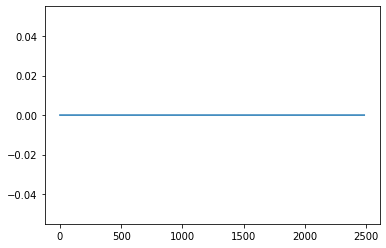

In [155]:
s.delta_stage_max_y.plot()

In [128]:
inference[(inference.date == pd.to_datetime('2013-05-18'))]

,year,station_id,month,day,date,delta_stage_max


In [144]:
        inference.loc[(inference.station_id == st)&(inference.date == d), 'delta_stage_max'].values


array([], dtype=float64)

In [140]:
for st in submit.station_id.unique():
    print(st)
    for d in submit[submit.station_id == st].date.unique():
        submit.loc[(submit.station_id == st)&(submit.date == d), 'delta_stage_max'] = \
        inference[(inference.station_id == st)&(inference.date == d)].delta_stage_max.values

#             inference[(inference.station_id == st)&(inference.date == d)].delta_stage_max.values
submit

3019


ValueError: cannot set using a multi-index selection indexer with a different length than the value

In [102]:
inference.loc[
    (inference.year == submit.year)& \
    (inference.station_id == submit.station_id),
    :
]

ValueError: Can only compare identically-labeled Series objects

In [138]:
for day in submit['date'].unique():
    for station in submit['station_id'].unique():
        submit.loc[(submit['date']==day) & (submit['station_id']==station), 'delta_stage_max'] = \
        inference.loc[(inference['date']==day) & (inference['station_id']==station)]['delta_stage_max'].values
        
submit

ValueError: cannot set using a multi-index selection indexer with a different length than the value

# Отработка методов и подходов

In [144]:
train_df = pd.read_csv(f'{RAWDATADIR}/track_2_package/train.csv', parse_dates=['date'])

# удаляем наблюдения за 1985-01-01, т.к. изменение уровня воды NaN из-за отсуютсвтия более ранних исторических данных
train_df.drop(train_df[train_df.date == pd.to_datetime('1985-01-01', format='%Y-%m-%d')].index, inplace=True)

### Киренск

In [128]:
tr_data = train_df[(train_df.station_id == kirensk_dict['id'])].copy()

# если замер льда не делали, то пусть 0 будет такой категорией
tr_data['place'].fillna(0, inplace=True)
# water_code и place должны быть категориальными
tr_data['water_code'] = tr_data['water_code'].astype('str')
tr_data['place'] = tr_data['place'].astype('int8')

tr_data.head()

,station_id,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place,discharge,year,month,day,delta_stage_max
0,3019,1985-01-01,-23.0,-23.0,-23.0,NaN,16,NaN,NaN,0,NaN,1985,1,1,NaN
1,3019,1985-01-02,-23.0,-23.0,-23.0,NaN,16,NaN,NaN,0,NaN,1985,1,2,0.0
2,3019,1985-01-03,-23.0,-23.0,-23.0,NaN,16,NaN,NaN,0,NaN,1985,1,3,0.0
3,3019,1985-01-04,-24.0,-24.0,-24.0,NaN,16,NaN,NaN,0,NaN,1985,1,4,-1.0
4,3019,1985-01-05,-24.0,-24.0,-24.0,NaN,16,53.0,29.0,1,NaN,1985,1,5,0.0


In [130]:
# проверка признаков на наличие пропусков
na_features = []
for col in tr_data.columns:
    cnt = tr_data[col].isna().sum()
    if cnt > 0:
        print(col, cnt)
        na_features.append(col)

temp 5372
ice_thickness 10945
snow_height 10968
discharge 11603


In [131]:
na_features

['temp', 'ice_thickness', 'snow_height', 'discharge']

In [132]:
# находим значения для заполнения праметров с пропусками, учитывая специфику каждого месяца

na_features_dict = dict()
for f in na_features:
    na_features_dict[f] = dict()

for feature in na_features:
    for i in range(1, 13):
#         if feature == 'place':
#             na_features_dict[feature][i] = tr_data.loc[tr_data.month == i, feature].mode().values[0]
#         else:
            val = tr_data.loc[tr_data.month == i, feature].mean()
            if (val is np.nan)&(feature == 'discharge'):
                na_features_dict[feature][i] = -1  # признак если среднего расхода воды не знаем или не замеряется на посту
            elif val is np.nan:
                na_features_dict[feature][i] = 0.0
            else:
                na_features_dict[feature][i] = val

na_features_dict

{'temp': {1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.09090909090909091,
  5: 4.593290322580645,
  6: 16.093793103448277,
  7: 20.633577712609974,
  8: 18.358797653958945,
  9: 10.244141414141415,
  10: 2.1803519061583576,
  11: 0.025,
  12: 0.0},
 'ice_thickness': {1: 53.78861788617886,
  2: 62.458333333333336,
  3: 65.61538461538461,
  4: 59.13414634146341,
  5: 41.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 10.0,
  11: 21.8125,
  12: 39.77777777777778},
 'snow_height': {1: 31.6260162601626,
  2: 36.94117647058823,
  3: 33.034188034188034,
  4: 14.603174603174603,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 5.5,
  11: 10.648936170212766,
  12: 24.384615384615383},
 'discharge': {1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1}}

In [133]:
# заполняем пропуски
for col in na_features:
    for i in range(1,13):
#         tr_data.loc[tr_data.month == i, col].fillna(value=na_features_dict[col][i], inplace=True)  # не работает...
        tr_data.loc[(tr_data.month == i)&(tr_data[col].isna()), col] = na_features_dict[col][i]
display(tr_data.head())
tr_data.info()

,station_id,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place,discharge,year,month,day,delta_stage_max
1,3019,1985-01-02,-23.0,-23.0,-23.0,0.0,16,53.788618,31.626016,0,-1.0,1985,1,2,0.0
2,3019,1985-01-03,-23.0,-23.0,-23.0,0.0,16,53.788618,31.626016,0,-1.0,1985,1,3,0.0
3,3019,1985-01-04,-24.0,-24.0,-24.0,0.0,16,53.788618,31.626016,0,-1.0,1985,1,4,-1.0
4,3019,1985-01-05,-24.0,-24.0,-24.0,0.0,16,53.000000,29.000000,1,-1.0,1985,1,5,0.0
5,3019,1985-01-06,-24.0,-24.0,-24.0,0.0,16,53.788618,31.626016,0,-1.0,1985,1,6,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11603 entries, 1 to 11603
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   station_id       11603 non-null  int64         
 1   date             11603 non-null  datetime64[ns]
 2   stage_avg        11603 non-null  float64       
 3   stage_min        11603 non-null  float64       
 4   stage_max        11603 non-null  float64       
 5   temp             11603 non-null  float64       
 6   water_code       11603 non-null  object        
 7   ice_thickness    11603 non-null  float64       
 8   snow_height      11603 non-null  float64       
 9   place            11603 non-null  int8          
 10  discharge        11603 non-null  float64       
 11  year             11603 non-null  int64         
 12  month            11603 non-null  int64         
 13  day              11603 non-null  int64         
 14  delta_stage_max  11603 non-null  float

### Гидрологические данные

In [176]:
tr_data = df_preprocessing(train_df, kirensk_dict['id'])
tr_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11603 entries, 1 to 11603
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   station_id       11603 non-null  int64         
 1   date             11603 non-null  datetime64[ns]
 2   stage_avg        11603 non-null  float64       
 3   stage_min        11603 non-null  float64       
 4   stage_max        11603 non-null  float64       
 5   temp             11603 non-null  float64       
 6   water_code       11603 non-null  object        
 7   ice_thickness    11603 non-null  float64       
 8   snow_height      11603 non-null  float64       
 9   place            11603 non-null  int8          
 10  discharge        11603 non-null  float64       
 11  year             11603 non-null  int64         
 12  month            11603 non-null  int64         
 13  day              11603 non-null  int64         
 14  delta_stage_max  11603 non-null  floa

In [177]:
# соберём данные со смежных постов, выделенных в словаре по данному целевому посту
mapper = dict()
use_feature = ['date', 'stage_avg', 'stage_min','stage_max', 'temp', 'water_code', 'ice_thickness','snow_height', 
               'place', 'discharge']

for n, st in enumerate(kirensk_dict['gydro_st']):
    if n == 0:
        # данные с поста
        df = df_preprocessing(train_df, st)
        df = df[use_feature]
        for col in [x for x in use_feature if x not in ['date']]:
            mapper[col] = f'{col}_{st}'
        gydro_st = df.rename(columns=mapper)
    else:
        # данные с поста
        df = df_preprocessing(train_df, st)
        df = df[use_feature]
        for col in [x for x in use_feature if x not in ['date']]:
            mapper[col] = f'{col}_{st}'
        df.rename(columns=mapper, inplace=True)
        gydro_st = pd.merge(gydro_st, df, on='date')

gydro_st.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 11603 entries, 0 to 11602
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                11603 non-null  datetime64[ns]
 1   stage_avg_3087      11603 non-null  float64       
 2   stage_min_3087      11603 non-null  float64       
 3   stage_max_3087      11603 non-null  float64       
 4   temp_3087           11603 non-null  float64       
 5   water_code_3087     11603 non-null  object        
 6   ice_thickness_3087  11603 non-null  float64       
 7   snow_height_3087    11603 non-null  float64       
 8   place_3087          11603 non-null  int8          
 9   discharge_3087      11603 non-null  float64       
 10  stage_avg_3021      11603 non-null  float64       
 11  stage_min_3021      11603 non-null  float64       
 12  stage_max_3021      11603 non-null  float64       
 13  temp_3021           11603 non-null  float64 

In [179]:
# сводные данные по целевому посту и его окресных гидропостов
kirensk_df = pd.merge(tr_data, gydro_st, on='date')
kirensk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11603 entries, 0 to 11602
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   station_id          11603 non-null  int64         
 1   date                11603 non-null  datetime64[ns]
 2   stage_avg           11603 non-null  float64       
 3   stage_min           11603 non-null  float64       
 4   stage_max           11603 non-null  float64       
 5   temp                11603 non-null  float64       
 6   water_code          11603 non-null  object        
 7   ice_thickness       11603 non-null  float64       
 8   snow_height         11603 non-null  float64       
 9   place               11603 non-null  int8          
 10  discharge           11603 non-null  float64       
 11  year                11603 non-null  int64         
 12  month               11603 non-null  int64         
 13  day                 11603 non-null  int64     

### Метеорологические данные

In [31]:
meteo_st = make_meteo_df(
    pd.read_csv(f'{RAWDATADIR}/track_2_package/meteo_3hours.csv', parse_dates=['date_local']),
    kirensk_dict['meteo_st']
)
sum(meteo_st.isna().sum())

0 30028
(12279, 38)
1 30219
(11363, 38)
2 30328
(11834, 38)
3 30337
(12279, 38)
4 30433
(12310, 38)
5 30230
(12279, 38)


0

In [10]:
# метеоданные
meteo_df = pd.read_csv(f'{RAWDATADIR}/track_2_package/meteo_3hours.csv', parse_dates=['date_local'])

# Замена np.nan'ами неподтверждённых или опровергнутых данных
_qual_cols = list(meteo_df.filter(regex='_qual$').columns)
print(meteo_df.shape)
for col in _qual_cols:
    meteo_df = mute_untrastable(meteo_df, col)
print(meteo_df.shape)

features = pd.Series(_qual_cols)
spl_feat = []
for n, f in enumerate(features):
    spl = features.values[n].split('_')
    spl_feat.append(('_'.join(spl[:len(spl)-1])))
    
use_feature = ['station_id', 'date_local', 'month_local'] + spl_feat

meteo_data = meteo_df[use_feature].copy()
print(meteo_data.shape)

del meteo_df
gc.collect()

(3666552, 94)
(3666552, 94)
(3666552, 39)


193

In [11]:
# аггрегация данных с дискретностью 1 день
meteo_1day = meteo_data.groupby(['station_id', 'date_local']).median()
meteo_1day.reset_index(inplace=True)
print(meteo_1day.shape)

del meteo_data
gc.collect()

(458319, 39)


0

In [18]:
mapper = dict()
use_feature = ['date_local', 'month_local'] + spl_feat

# берём данные по нужным станциям
for n, st in enumerate(kirensk_dict['meteo_st']):
    print(n, st)
    if n == 0:
        df = meteo_data_processing(meteo_1day, st)
        df = df[use_feature]
        print(df.shape)
        for col in spl_feat:
            mapper[col] = f'{col}_{st}'
        meteo_st = df.rename(columns=mapper)
    else:
        df = meteo_data_processing(meteo_1day, st)
        df = df[use_feature]
        print(df.shape)
        for col in spl_feat:
            mapper[col] = f'{col}_{st}'
        df.rename(columns=mapper, inplace=True)
        meteo_st = pd.merge(meteo_st, df, how='outer', on=['date_local', 'month_local'])

meteo_st.shape

0 30028


/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
 

(12279, 38)
1 30219


/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
 

(11363, 38)
2 30328


/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
 

(11834, 38)
3 30337


/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
 

(12279, 38)
4 30433


/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
 

(12310, 38)
5 30230


/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
 

(12279, 38)


(12310, 218)

In [19]:
meteo_st.shape

(12310, 218)

In [20]:
meteo_st.tail()

,date_local,month_local,horizontal_visibility_30028,cloud_amount_total_30028,cloud_amount_low_level_30028,cloud_form_high_level_30028,cloud_form_middle_level_30028,cloud_form_vertical_develop_30028,cloud_form_strat_stratocum_30028,cloud_form_strat_rain_30028,...,air_temperature_max_before_30230,air_max_temperature_30230,water_vapour_partial_pressure_30230,relative_humidity_30230,vapour_pressure_deficit_30230,dew_point_temperature_30230,pressure_30230,pressure_sea_level_30230,barometric_tendency_characteristic_30230,barometric_tendency_30230
12305,2020-01-27,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12306,2020-01-28,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12307,2020-01-29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12308,2020-01-30,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12309,2020-01-31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
        # находим значения для заполнения праметров с пропусками, учитывая специфику каждого месяца
        features_dict = dict()
        features = [x for x in meteo_st.columns if x not in ['date_local', 'month_local']]
        for f in features:
            features_dict[f] = dict()
        for feature in features:
            for i in range(1, 13):
                val = meteo_st.loc[meteo_st.month_local == i, feature].median()
                if (val is not np.nan)|(val is not pd.NA)|(val != 'nan'):
                    features_dict[feature][i] = val
                else:
                    features_dict[feature][i] = -777
#         features_dict                
        # заполняем пропуски
        for col in features:
            for i in range(1,13):
                meteo_st.loc[(meteo_st.month_local == i)&(meteo_st[col].isna()), col] = features_dict[col][i]
                
        meteo_st.fillna(-777, inplace=True)

/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/msemezhov/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
 

In [26]:
meteo_st.tail()

,date_local,month_local,horizontal_visibility_30028,cloud_amount_total_30028,cloud_amount_low_level_30028,cloud_form_high_level_30028,cloud_form_middle_level_30028,cloud_form_vertical_develop_30028,cloud_form_strat_stratocum_30028,cloud_form_strat_rain_30028,...,air_temperature_max_before_30230,air_max_temperature_30230,water_vapour_partial_pressure_30230,relative_humidity_30230,vapour_pressure_deficit_30230,dew_point_temperature_30230,pressure_30230,pressure_sea_level_30230,barometric_tendency_characteristic_30230,barometric_tendency_30230
12305,2020-01-27,1,97.0,6.5,0.0,1.0,0.0,0.0,0.0,0.0,...,-23.15,-24.35,0.57,77.5,0.135,-29.05,996.05,1032.4,5.0,0.8
12306,2020-01-28,1,97.0,6.5,0.0,1.0,0.0,0.0,0.0,0.0,...,-23.15,-24.35,0.57,77.5,0.135,-29.05,996.05,1032.4,5.0,0.8
12307,2020-01-29,1,97.0,6.5,0.0,1.0,0.0,0.0,0.0,0.0,...,-23.15,-24.35,0.57,77.5,0.135,-29.05,996.05,1032.4,5.0,0.8
12308,2020-01-30,1,97.0,6.5,0.0,1.0,0.0,0.0,0.0,0.0,...,-23.15,-24.35,0.57,77.5,0.135,-29.05,996.05,1032.4,5.0,0.8
12309,2020-01-31,1,97.0,6.5,0.0,1.0,0.0,0.0,0.0,0.0,...,-23.15,-24.35,0.57,77.5,0.135,-29.05,996.05,1032.4,5.0,0.8


In [27]:
sum(meteo_st.isna().sum())

0

In [33]:
kirensk_dict['meteo_st']

[30028, 30219, 30328, 30337, 30433, 30230]